## Importing required libraries

In [23]:
%%capture
!pip install iterative-stratification tensorflow-addons

import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import RMSprop,Adam,SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.applications import DenseNet121, MobileNetV2, EfficientNetB1, VGG19, InceptionV3
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, BatchNormalization,Dropout,Flatten,Input,Conv2D
from tensorflow.keras.models import Model

import warnings
warnings.filterwarnings('ignore')


In [33]:
# ===== Config =====
IMG_SIZE = (240, 240)
#IMG_SIZE =  (224,224) #vgg
#IMG_SIZE =  (299,299) #inceptionv3
BATCH_SIZE = 32
EPOCHS = 20
NUM_CLASSES = 7
IMAGE_DIR = '/kaggle/input/my-seminar-dataset/wfd_dataset/wfd_dataset'  # Change if your images are elsewhere
data_path = '/kaggle/input/my-seminar-dataset/data.csv'

## Data Loading & Splitting data into train_test_validation

In [4]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import pandas as pd
import numpy as np


def load_data(data_path,
             display_first = 0):
    
    data = pd.read_csv(data_path)
    
    ids = data['img'].str.split('_').apply(lambda x: x[1])
    data.drop(columns = ['img'],inplace=True)
    data.insert(0,'id',ids)
    
    # shuffle
    data = data.sample(frac=1, random_state=42).reset_index(drop=True)

    # splitting 
    X = data["id"].values
    Y = data.iloc[:, 1:].values  # All label columns
    
    print(f"Total datapoints we have = {len(X)}")
    
    # First split: Train (70%) vs Temp (30%)
    mskf = MultilabelStratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    for train_index, temp_index in mskf.split(X, Y):
        X_train, X_temp = X[train_index], X[temp_index]
        Y_train, Y_temp = Y[train_index], Y[temp_index]
        break 
    
    # Second split: Temp → Val (15%) and Test (15%)
    X_temp_df = pd.DataFrame(X_temp, columns=["id"])
    Y_temp_df = pd.DataFrame(Y_temp, columns=data.columns[1:])
    temp_df = pd.concat([X_temp_df, Y_temp_df], axis=1)
    
    mskf_temp = MultilabelStratifiedKFold(n_splits=2, shuffle=True, random_state=42)
    for val_index, test_index in mskf_temp.split(X_temp_df.values, Y_temp_df.values):
        X_val, X_test = X_temp[val_index], X_temp[test_index]
        Y_val, Y_test = Y_temp[val_index], Y_temp[test_index]
        break
    
    # Create final DataFrames
    data_train = data[data["id"].isin(X_train)].reset_index(drop=True)
    data_valid = data[data["id"].isin(X_val)].reset_index(drop=True)
    data_test  = data[data["id"].isin(X_test)].reset_index(drop=True)
    
    print(f"My training set has = {data_train.shape[0]} examples.")
    print(f"My test set has = {data_test.shape[0]} examples.")
    print(f"My valid set has = {data_valid.shape[0]} examples.")

    if display_first != 0:
        display(data_train.head(display_first))
        display(data_test.head(display_first))

    return (data_train, data_valid, data_test)

In [34]:
data_train, data_valid, data_test = load_data(data_path)

Total datapoints we have = 2414
My training set has = 1606 examples.
My test set has = 410 examples.
My valid set has = 398 examples.


## Visualize random images from dataset

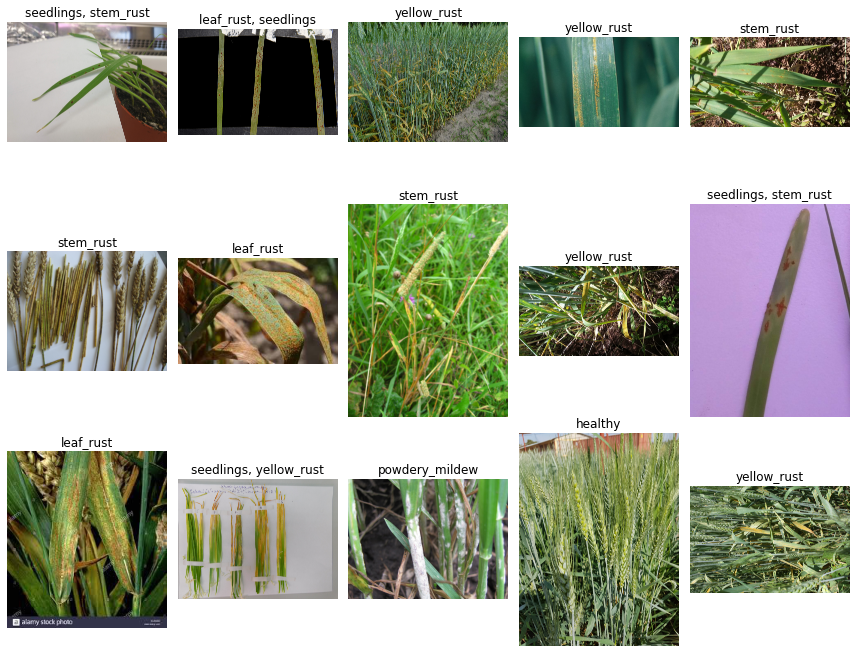

In [6]:
import random
import numpy as np
random.seed(42)
import os
from PIL import Image

labels = data_train.columns[1:]

def get_labels(row):
    return [label for label in labels if row[label] == 1]

N = 15
nth = data_train.sample(N)


def display_samples(mdf, n=9):
    plt.figure(figsize=(12, 10))

    for i, (_, row) in enumerate(mdf.iterrows()):
        img_path = os.path.join('/kaggle/input/my-seminar-dataset/wfd_dataset/wfd_dataset', row["id"])
        img = Image.open(img_path).convert("RGB")

        plt.subplot(3, 5, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(", ".join(get_labels(row)))

    plt.tight_layout()
    plt.show()


display_samples(nth, N)


### visualizing distribution of dataset

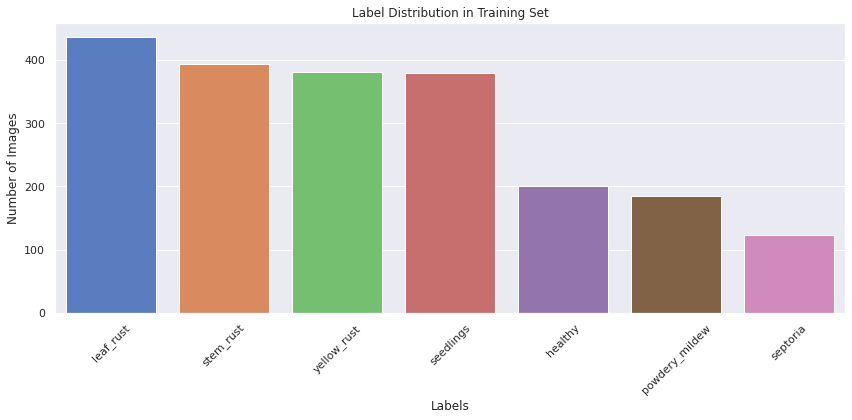

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set()


train_d = data_train.drop(columns=['id'])

label_counts = train_d.sum().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="muted")
plt.xticks(rotation=45)
plt.xlabel("Labels")
plt.ylabel("Number of Images")
plt.title("Label Distribution in Training Set")
plt.tight_layout()
plt.show()


## Preprocessing Dataset

In [35]:
def preprocess(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        img = tf.cast(img, tf.float32) / 255.0
        return img, label
   
def df_to_dataset(df, is_train=True):
    image_paths = df['id'].apply(lambda x: os.path.join(IMAGE_DIR, x)).values
    labels = df.iloc[:, 1:].values.astype('float32')  # Skip 'id' column

    ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    
    ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if is_train:
        ds = ds.shuffle(1000)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


## Model building

In [36]:
# ===== Build Model =====
def build_model(model_name,img_size):
    if model_name == "DenseNet121":
        base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(*img_size, 3))
    elif model_name == "ResNet50":
        base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(*img_size, 3))
    elif model_name == "EfficientNetB1":
        base_model = EfficientNetB1(include_top=False, weights='imagenet', input_shape=(*img_size, 3))
    elif model_name == "MobileNetV2":
        base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(*img_size, 3))
    elif model_name == "VGG19":
        base_model = VGG19(include_top=False, weights='imagenet', input_shape=(*img_size, 3))
    elif model_name == "InceptionV3":
        base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(*img_size, 3))
    else:
        raise "No suitable model found"
        
    
    base_model.trainable = False  # Freeze for transfer learning

    inputs = Input(shape=(*img_size, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(NUM_CLASSES, activation='sigmoid')(x) 
    return Model(inputs, outputs)


def DiseaseClassifier(model_name, 
                      train_epochs,
                      num_classes,
                      callbacks,
                      img_size):
    
    model = build_model(model_name=model_name,
                        img_size=img_size)

    # ===== Compile =====
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=[
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tfa.metrics.F1Score(num_classes=num_classes, average='micro',name='f1_micro')  # or 'micro'
    
        ]
    )

    # ===== Train =====
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=train_epochs,
        callbacks=callbacks
    )

    return model, history


def evaluate_model(train_ds, val_ds, test_ds, model):
    
    # ==== Test =====
    train_results = model.evaluate(train_ds)
    val_results = model.evaluate(val_ds)
    test_results = model.evaluate(test_ds)

    res_df_noft = {
        'loss':[],
        'precision':[],
        'recall':[],
        'f1_micro':[]
    }

    for my_res_noft in [train_results,val_results, test_results]:
        res_df_noft['loss'].append(my_res_noft[0])
        res_df_noft['precision'].append(my_res_noft[1])
        res_df_noft['recall'].append(my_res_noft[2])
        res_df_noft['f1_micro'].append(my_res_noft[3])
    

    res_df_noft = pd.DataFrame(res_df_noft)
    res_df_noft = res_df_noft.apply(lambda x: round(x*100,2))
    return res_df_noft


#import tensorflow_addons as tfa
#'/kaggle/input/densenet121_new/tensorflow2/default/1/best_model_DenseNet121_new.h5',

# ====== Reloading model  ==========
from tensorflow.keras.models import load_model

def load_from_local(model_path):
    return load_model(
        model_path,
        custom_objects={
            "F1Score": tfa.metrics.F1Score(num_classes=NUM_CLASSES, average='micro')
        }
    )

In [37]:
def finetune(model,
             train_ds,
             val_ds,
             callbacks, 
             ft_lr = 1e-5, ft_epochs = 10, num_classes = 7):

    
    model.get_layer(index=1).trainable = True  # Unfreeze base model
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(ft_lr),
        loss='binary_crossentropy',
        metrics=[
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tfa.metrics.F1Score(num_classes=num_classes, average='micro', name='f1_micro')
        ]
    )
    ft_history = model.fit(train_ds, validation_data=val_ds, epochs=ft_epochs, callbacks=callbacks)

    return model, ft_history

# Tranfer Learning with DenseNet121

In [20]:
train_ds = df_to_dataset(data_train, is_train=True)
val_ds = df_to_dataset(data_valid, is_train=False)
test_ds = df_to_dataset(data_test, is_train=False)

MODEL_NAME = 'DenseNet121'

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3),
    ModelCheckpoint('best_model_DenseNet121.h5', save_best_only=True),
     #MicroPrecisionCallback(val_ds)
]

print(f"PERFORMING TRANSFER LEARNING FOR '{MODEL_NAME}'")
denseNet_trained,denseNet_history = DiseaseClassifier(
    model_name=MODEL_NAME,
    train_epochs= EPOCHS,
    num_classes=NUM_CLASSES,
    callbacks=callbacks,
    img_size=IMG_SIZE
)

result_df = evaluate_model(
    model = denseNet_trained,
    train_ds = train_ds,
    val_ds = val_ds,
    test_ds = test_ds
)

result_df

## Fine-tuning of DenseNet121 

In [26]:
ft_model, _ = finetune(
    model=denseNet_trained,
    train_ds,
    val_ds,
    callbacks,
    ft_lr = 1e-5,
    ft_epochs=2,
)

evaluate_model(train_ds, val_ds, test_ds, ft_model)

Cleanup called...


 1/13 [=>............................] - ETA: 7s - loss: 0.2703 - precision: 0.8571 - recall: 0.6000 - f1_micro: 0.6389

Cleanup called...


13/13 [==============================] - 8s 612ms/step - loss: 0.2741 - precision: 0.8255 - recall: 0.5698 - f1_micro: 0.5874


,loss,precision,recall,f1_micro
0,23.60,88.38,61.57,66.32
1,26.92,83.38,54.58,61.61
2,27.41,82.55,56.98,58.74


# Transfer Learning with MobileNetV2

In [12]:
train_ds = df_to_dataset(data_train, is_train=True)
val_ds = df_to_dataset(data_valid, is_train=False)
test_ds = df_to_dataset(data_test, is_train=False)

MODEL_NAME = 'MobileNetV2'

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3),
    ModelCheckpoint(f'best_model_{MODEL_NAME}.h5', save_best_only=True),
     #MicroPrecisionCallback(val_ds)
]

print(f"PERFORMING TRANSFER LEARNING FOR '{MODEL_NAME}'")
trained_model,model_history = DiseaseClassifier(
    model_name=MODEL_NAME,
    train_epochs= EPOCHS,
    num_classes=NUM_CLASSES,
    callbacks=callbacks,
    img_size=IMG_SIZE
)

result_df = evaluate_model(
    model = trained_model,
    train_ds = train_ds,
    val_ds = val_ds,
    test_ds = test_ds
)

result_df

PERFORMING TRANSFER LEARNING FOR 'MobileNetV2'
9420800/9406464 [==============================] - 1s 0us/step
Epoch 1/20


Cleanup called...


51/51 [==============================] - 71s 591ms/step - loss: 0.4447 - precision: 0.5356 - recall: 0.2724 - f1_micro: 0.3751 - val_loss: 0.3342 - val_precision: 0.8179 - val_recall: 0.4370 - val_f1_micro: 0.5119
Epoch 2/20


Cleanup called...


51/51 [==============================] - 50s 488ms/step - loss: 0.3328 - precision: 0.7269 - recall: 0.4424 - f1_micro: 0.5321 - val_loss: 0.2974 - val_precision: 0.8199 - val_recall: 0.5038 - val_f1_micro: 0.5531
Epoch 3/20


Cleanup called...


51/51 [==============================] - 49s 470ms/step - loss: 0.2993 - precision: 0.7606 - recall: 0.5114 - f1_micro: 0.5542 - val_loss: 0.2732 - val_precision: 0.8150 - val_recall: 0.5802 - val_f1_micro: 0.5900
Epoch 4/20


Cleanup called...


51/51 [==============================] - 51s 491ms/step - loss: 0.2719 - precision: 0.7688 - recall: 0.5557 - f1_micro: 0.6055 - val_loss: 0.2643 - val_precision: 0.7955 - val_recall: 0.6011 - val_f1_micro: 0.5770
Epoch 5/20


Cleanup called...


51/51 [==============================] - 51s 494ms/step - loss: 0.2519 - precision: 0.7961 - recall: 0.5967 - f1_micro: 0.6044 - val_loss: 0.2508 - val_precision: 0.8418 - val_recall: 0.5992 - val_f1_micro: 0.5965
Epoch 6/20


Cleanup called...


51/51 [==============================] - 48s 476ms/step - loss: 0.2337 - precision: 0.8261 - recall: 0.6357 - f1_micro: 0.6449 - val_loss: 0.2394 - val_precision: 0.8526 - val_recall: 0.6183 - val_f1_micro: 0.6182
Epoch 7/20


Cleanup called...


51/51 [==============================] - 51s 491ms/step - loss: 0.2218 - precision: 0.8279 - recall: 0.6481 - f1_micro: 0.6562 - val_loss: 0.2555 - val_precision: 0.7975 - val_recall: 0.6011 - val_f1_micro: 0.5944
Epoch 8/20


Cleanup called...


51/51 [==============================] - 50s 483ms/step - loss: 0.2095 - precision: 0.8480 - recall: 0.6748 - f1_micro: 0.6740 - val_loss: 0.2365 - val_precision: 0.8317 - val_recall: 0.6317 - val_f1_micro: 0.6226
Epoch 9/20


Cleanup called...


51/51 [==============================] - 51s 491ms/step - loss: 0.1971 - precision: 0.8397 - recall: 0.6957 - f1_micro: 0.6827 - val_loss: 0.2292 - val_precision: 0.8190 - val_recall: 0.6737 - val_f1_micro: 0.6356
Epoch 10/20


Cleanup called...


51/51 [==============================] - 50s 471ms/step - loss: 0.1858 - precision: 0.8664 - recall: 0.7071 - f1_micro: 0.6865 - val_loss: 0.2281 - val_precision: 0.8148 - val_recall: 0.6718 - val_f1_micro: 0.6399
Epoch 11/20


Cleanup called...


51/51 [==============================] - 49s 481ms/step - loss: 0.1841 - precision: 0.8569 - recall: 0.7243 - f1_micro: 0.6956 - val_loss: 0.2278 - val_precision: 0.8117 - val_recall: 0.6908 - val_f1_micro: 0.6334
Epoch 12/20


Cleanup called...


51/51 [==============================] - 50s 478ms/step - loss: 0.1722 - precision: 0.8619 - recall: 0.7457 - f1_micro: 0.7140 - val_loss: 0.2261 - val_precision: 0.8222 - val_recall: 0.6794 - val_f1_micro: 0.6356
Epoch 13/20


Cleanup called...


51/51 [==============================] - 51s 491ms/step - loss: 0.1692 - precision: 0.8620 - recall: 0.7433 - f1_micro: 0.7156 - val_loss: 0.2241 - val_precision: 0.8188 - val_recall: 0.6813 - val_f1_micro: 0.6421
Epoch 14/20


Cleanup called...


51/51 [==============================] - 50s 488ms/step - loss: 0.1595 - precision: 0.8782 - recall: 0.7590 - f1_micro: 0.7302 - val_loss: 0.2221 - val_precision: 0.8110 - val_recall: 0.7042 - val_f1_micro: 0.6529
Epoch 15/20


Cleanup called...


51/51 [==============================] - 50s 482ms/step - loss: 0.1472 - precision: 0.8797 - recall: 0.7871 - f1_micro: 0.7388 - val_loss: 0.2219 - val_precision: 0.8421 - val_recall: 0.6718 - val_f1_micro: 0.6594
Epoch 16/20


Cleanup called...


51/51 [==============================] - 48s 466ms/step - loss: 0.1430 - precision: 0.8980 - recall: 0.7886 - f1_micro: 0.7415 - val_loss: 0.2248 - val_precision: 0.8288 - val_recall: 0.6927 - val_f1_micro: 0.6508
Epoch 17/20


Cleanup called...


51/51 [==============================] - 49s 476ms/step - loss: 0.1395 - precision: 0.9018 - recall: 0.7919 - f1_micro: 0.7523 - val_loss: 0.2158 - val_precision: 0.8082 - val_recall: 0.7156 - val_f1_micro: 0.6486
Epoch 18/20


Cleanup called...


51/51 [==============================] - 51s 489ms/step - loss: 0.1354 - precision: 0.9054 - recall: 0.8067 - f1_micro: 0.7534 - val_loss: 0.2172 - val_precision: 0.8458 - val_recall: 0.7118 - val_f1_micro: 0.6616
Epoch 19/20


Cleanup called...


51/51 [==============================] - 50s 487ms/step - loss: 0.1245 - precision: 0.9060 - recall: 0.8171 - f1_micro: 0.7717 - val_loss: 0.2164 - val_precision: 0.8311 - val_recall: 0.6947 - val_f1_micro: 0.6681
Epoch 20/20


Cleanup called...


51/51 [==============================] - 50s 469ms/step - loss: 0.1209 - precision: 0.9145 - recall: 0.8305 - f1_micro: 0.7712 - val_loss: 0.2180 - val_precision: 0.8060 - val_recall: 0.7214 - val_f1_micro: 0.6508


Cleanup called...


 1/13 [=>............................] - ETA: 10s - loss: 0.1721 - precision: 0.8710 - recall: 0.6750 - f1_micro: 0.6667

Cleanup called...


13/13 [==============================] - 10s 751ms/step - loss: 0.2192 - precision: 0.8130 - recall: 0.7151 - f1_micro: 0.6431


,loss,precision,recall,f1_micro
0,6.49,97.95,95.52,84.84
1,21.80,80.60,72.14,65.08
2,21.92,81.30,71.51,64.31


## Finetuning MobileNetV2

In [17]:
FT_EPOCHS = 10
FT_LR = 1e-5

ft_model, _ = finetune(
    trained_model,
    train_ds,
    val_ds,
    callbacks,
    ft_lr = FT_LR,
    ft_epochs=FT_EPOCHS
)

evaluate_model(train_ds, val_ds, test_ds, ft_model)

Epoch 1/10


Cleanup called...


51/51 [==============================] - 61s 596ms/step - loss: 0.1193 - precision: 0.9070 - recall: 0.8357 - f1_micro: 0.7679 - val_loss: 0.2226 - val_precision: 0.8017 - val_recall: 0.7328 - val_f1_micro: 0.6594
Epoch 2/10


Cleanup called...


51/51 [==============================] - 57s 608ms/step - loss: 0.1027 - precision: 0.9231 - recall: 0.8633 - f1_micro: 0.7902 - val_loss: 0.2196 - val_precision: 0.8312 - val_recall: 0.7328 - val_f1_micro: 0.6725
Epoch 3/10


Cleanup called...


51/51 [==============================] - 56s 589ms/step - loss: 0.0911 - precision: 0.9315 - recall: 0.8867 - f1_micro: 0.7972 - val_loss: 0.2258 - val_precision: 0.8174 - val_recall: 0.7347 - val_f1_micro: 0.6659
Epoch 4/10


Cleanup called...


51/51 [==============================] - 56s 603ms/step - loss: 0.0896 - precision: 0.9308 - recall: 0.8833 - f1_micro: 0.8014 - val_loss: 0.2215 - val_precision: 0.8426 - val_recall: 0.7252 - val_f1_micro: 0.6746
Epoch 5/10


Cleanup called...


51/51 [==============================] - 56s 593ms/step - loss: 0.0887 - precision: 0.9404 - recall: 0.8862 - f1_micro: 0.8066 - val_loss: 0.2241 - val_precision: 0.8114 - val_recall: 0.7309 - val_f1_micro: 0.6638
Epoch 6/10


Cleanup called...


51/51 [==============================] - 56s 596ms/step - loss: 0.0758 - precision: 0.9464 - recall: 0.9081 - f1_micro: 0.8230 - val_loss: 0.2167 - val_precision: 0.8443 - val_recall: 0.7347 - val_f1_micro: 0.6811
Epoch 7/10


Cleanup called...


51/51 [==============================] - 54s 588ms/step - loss: 0.0708 - precision: 0.9480 - recall: 0.9195 - f1_micro: 0.8271 - val_loss: 0.2149 - val_precision: 0.8359 - val_recall: 0.7385 - val_f1_micro: 0.6746
Epoch 8/10


Cleanup called...


51/51 [==============================] - 56s 597ms/step - loss: 0.0707 - precision: 0.9426 - recall: 0.9143 - f1_micro: 0.8288 - val_loss: 0.2184 - val_precision: 0.8359 - val_recall: 0.7385 - val_f1_micro: 0.6790
Epoch 9/10


Cleanup called...


51/51 [==============================] - 56s 585ms/step - loss: 0.0654 - precision: 0.9495 - recall: 0.9224 - f1_micro: 0.8340 - val_loss: 0.2187 - val_precision: 0.8373 - val_recall: 0.7366 - val_f1_micro: 0.6811
Epoch 10/10


Cleanup called...


51/51 [==============================] - 56s 586ms/step - loss: 0.0683 - precision: 0.9528 - recall: 0.9224 - f1_micro: 0.8334 - val_loss: 0.2185 - val_precision: 0.8351 - val_recall: 0.7443 - val_f1_micro: 0.6746


Cleanup called...


 1/13 [=>............................] - ETA: 7s - loss: 0.1609 - precision: 0.8571 - recall: 0.7500 - f1_micro: 0.6667

Cleanup called...


13/13 [==============================] - 8s 606ms/step - loss: 0.2158 - precision: 0.8169 - recall: 0.7591 - f1_micro: 0.6710


,loss,precision,recall,f1_micro
0,3.16,99.38,98.62,86.46
1,21.85,83.51,74.43,67.46
2,21.58,81.69,75.91,67.10


# Transfer Learning with VGG19

In [25]:
train_ds = df_to_dataset(data_train, is_train=True)
val_ds = df_to_dataset(data_valid, is_train=False)
test_ds = df_to_dataset(data_test, is_train=False)

MODEL_NAME = 'VGG19'

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3),
    ModelCheckpoint(f'best_model_{MODEL_NAME}.h5', save_best_only=True),
     #MicroPrecisionCallback(val_ds)
]

print(f"PERFORMING TRANSFER LEARNING FOR '{MODEL_NAME}'")
trained_model,model_history = DiseaseClassifier(
    model_name=MODEL_NAME,
    train_epochs= EPOCHS,
    num_classes=NUM_CLASSES,
    callbacks=callbacks,
    img_size=IMG_SIZE
)

result_df = evaluate_model(
    model = trained_model,
    train_ds = train_ds,
    val_ds = val_ds,
    test_ds = test_ds
)

result_df

PERFORMING TRANSFER LEARNING FOR 'VGG19'
Epoch 1/20


Cleanup called...


51/51 [==============================] - 55s 539ms/step - loss: 0.4957 - precision: 0.2688 - recall: 0.0614 - f1_micro: 0.2531 - val_loss: 0.4464 - val_precision: 0.7674 - val_recall: 0.0630 - val_f1_micro: 0.3102
Epoch 2/20


Cleanup called...


51/51 [==============================] - 52s 512ms/step - loss: 0.4440 - precision: 0.6331 - recall: 0.1019 - f1_micro: 0.3157 - val_loss: 0.4287 - val_precision: 0.7093 - val_recall: 0.1164 - val_f1_micro: 0.3275
Epoch 3/20


Cleanup called...


51/51 [==============================] - 50s 493ms/step - loss: 0.4357 - precision: 0.6570 - recall: 0.1295 - f1_micro: 0.3405 - val_loss: 0.4199 - val_precision: 0.8302 - val_recall: 0.0840 - val_f1_micro: 0.4100
Epoch 4/20


Cleanup called...


51/51 [==============================] - 52s 512ms/step - loss: 0.4239 - precision: 0.6595 - recall: 0.1310 - f1_micro: 0.3486 - val_loss: 0.4127 - val_precision: 0.6754 - val_recall: 0.1469 - val_f1_micro: 0.4208
Epoch 5/20


Cleanup called...


51/51 [==============================] - 49s 493ms/step - loss: 0.4131 - precision: 0.7093 - recall: 0.1557 - f1_micro: 0.3664 - val_loss: 0.4025 - val_precision: 0.7692 - val_recall: 0.1527 - val_f1_micro: 0.3948
Epoch 6/20


Cleanup called...


51/51 [==============================] - 51s 505ms/step - loss: 0.4057 - precision: 0.6860 - recall: 0.1686 - f1_micro: 0.3826 - val_loss: 0.3963 - val_precision: 0.8660 - val_recall: 0.1603 - val_f1_micro: 0.4056
Epoch 7/20


Cleanup called...


51/51 [==============================] - 52s 521ms/step - loss: 0.4000 - precision: 0.7177 - recall: 0.1852 - f1_micro: 0.3929 - val_loss: 0.3899 - val_precision: 0.7625 - val_recall: 0.2328 - val_f1_micro: 0.4317
Epoch 8/20


Cleanup called...


51/51 [==============================] - 51s 518ms/step - loss: 0.3896 - precision: 0.7256 - recall: 0.2052 - f1_micro: 0.4161 - val_loss: 0.3824 - val_precision: 0.7863 - val_recall: 0.1966 - val_f1_micro: 0.4512
Epoch 9/20


Cleanup called...


51/51 [==============================] - 52s 512ms/step - loss: 0.3861 - precision: 0.7342 - recall: 0.2210 - f1_micro: 0.4204 - val_loss: 0.3793 - val_precision: 0.8293 - val_recall: 0.1947 - val_f1_micro: 0.4490
Epoch 10/20


Cleanup called...


51/51 [==============================] - 53s 517ms/step - loss: 0.3862 - precision: 0.7240 - recall: 0.2324 - f1_micro: 0.4258 - val_loss: 0.3783 - val_precision: 0.8054 - val_recall: 0.2290 - val_f1_micro: 0.4338
Epoch 11/20


Cleanup called...


51/51 [==============================] - 51s 499ms/step - loss: 0.3850 - precision: 0.7131 - recall: 0.2390 - f1_micro: 0.4161 - val_loss: 0.3758 - val_precision: 0.7885 - val_recall: 0.2347 - val_f1_micro: 0.4620
Epoch 12/20


Cleanup called...


51/51 [==============================] - 52s 515ms/step - loss: 0.3807 - precision: 0.7393 - recall: 0.2376 - f1_micro: 0.4290 - val_loss: 0.3674 - val_precision: 0.7870 - val_recall: 0.2538 - val_f1_micro: 0.4534
Epoch 13/20


Cleanup called...


51/51 [==============================] - 51s 501ms/step - loss: 0.3763 - precision: 0.7319 - recall: 0.2510 - f1_micro: 0.4301 - val_loss: 0.3705 - val_precision: 0.7500 - val_recall: 0.2748 - val_f1_micro: 0.4534
Epoch 14/20


Cleanup called...


51/51 [==============================] - 51s 518ms/step - loss: 0.3716 - precision: 0.7360 - recall: 0.2695 - f1_micro: 0.4398 - val_loss: 0.3739 - val_precision: 0.7210 - val_recall: 0.3206 - val_f1_micro: 0.4534
Epoch 15/20


Cleanup called...


51/51 [==============================] - 52s 523ms/step - loss: 0.3751 - precision: 0.7148 - recall: 0.2638 - f1_micro: 0.4296 - val_loss: 0.3690 - val_precision: 0.8000 - val_recall: 0.2443 - val_f1_micro: 0.4664
Epoch 16/20


Cleanup called...


51/51 [==============================] - 51s 510ms/step - loss: 0.3656 - precision: 0.7851 - recall: 0.2610 - f1_micro: 0.4485 - val_loss: 0.3619 - val_precision: 0.8000 - val_recall: 0.2824 - val_f1_micro: 0.4772
Epoch 17/20


Cleanup called...


51/51 [==============================] - 52s 516ms/step - loss: 0.3683 - precision: 0.7504 - recall: 0.2462 - f1_micro: 0.4393 - val_loss: 0.3616 - val_precision: 0.7734 - val_recall: 0.2996 - val_f1_micro: 0.4751
Epoch 18/20


Cleanup called...


51/51 [==============================] - 51s 499ms/step - loss: 0.3619 - precision: 0.7573 - recall: 0.2705 - f1_micro: 0.4501 - val_loss: 0.3592 - val_precision: 0.7926 - val_recall: 0.2844 - val_f1_micro: 0.4729
Epoch 19/20


Cleanup called...


51/51 [==============================] - 52s 510ms/step - loss: 0.3641 - precision: 0.7553 - recall: 0.2719 - f1_micro: 0.4555 - val_loss: 0.3607 - val_precision: 0.7608 - val_recall: 0.3034 - val_f1_micro: 0.4794
Epoch 20/20


Cleanup called...


51/51 [==============================] - 52s 511ms/step - loss: 0.3627 - precision: 0.7516 - recall: 0.2781 - f1_micro: 0.4468 - val_loss: 0.3587 - val_precision: 0.7662 - val_recall: 0.2939 - val_f1_micro: 0.4751


Cleanup called...


 1/13 [=>............................] - ETA: 7s - loss: 0.3604 - precision: 0.7273 - recall: 0.2000 - f1_micro: 0.4167

Cleanup called...


13/13 [==============================] - 11s 842ms/step - loss: 0.3524 - precision: 0.8177 - recall: 0.3002 - f1_micro: 0.4737


,loss,precision,recall,f1_micro
0,33.14,86.47,35.62,51.00
1,35.87,76.62,29.39,47.51
2,35.24,81.77,30.02,47.37


## Finetuning of VGG19

In [26]:
FT_EPOCHS = 10
FT_LR = 1e-5


callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3),
    ModelCheckpoint(f'best_model_{MODEL_NAME}_FT.h5', save_best_only=True),
     #MicroPrecisionCallback(val_ds)
]

ft_model, _ = finetune(
    trained_model,
    train_ds,
    val_ds,
    callbacks,
    ft_lr = FT_LR,
    ft_epochs=FT_EPOCHS
)

evaluate_model(train_ds, val_ds, test_ds, ft_model)

Epoch 1/10


Cleanup called...


51/51 [==============================] - 60s 621ms/step - loss: 0.3422 - precision: 0.7398 - recall: 0.3695 - f1_micro: 0.4808 - val_loss: 0.3237 - val_precision: 0.8000 - val_recall: 0.4046 - val_f1_micro: 0.5141
Epoch 2/10


Cleanup called...


51/51 [==============================] - 57s 615ms/step - loss: 0.3000 - precision: 0.7783 - recall: 0.4648 - f1_micro: 0.5515 - val_loss: 0.2961 - val_precision: 0.8031 - val_recall: 0.4905 - val_f1_micro: 0.5466
Epoch 3/10


Cleanup called...


51/51 [==============================] - 57s 622ms/step - loss: 0.2708 - precision: 0.8038 - recall: 0.5305 - f1_micro: 0.5613 - val_loss: 0.2839 - val_precision: 0.8042 - val_recall: 0.5095 - val_f1_micro: 0.5597
Epoch 4/10


Cleanup called...


51/51 [==============================] - 57s 607ms/step - loss: 0.2432 - precision: 0.8269 - recall: 0.5890 - f1_micro: 0.6071 - val_loss: 0.2755 - val_precision: 0.7951 - val_recall: 0.5630 - val_f1_micro: 0.5857
Epoch 5/10


Cleanup called...


51/51 [==============================] - 57s 616ms/step - loss: 0.2222 - precision: 0.8476 - recall: 0.6381 - f1_micro: 0.6350 - val_loss: 0.2949 - val_precision: 0.7252 - val_recall: 0.5992 - val_f1_micro: 0.5792
Epoch 6/10


Cleanup called...


51/51 [==============================] - 57s 610ms/step - loss: 0.2104 - precision: 0.8477 - recall: 0.6705 - f1_micro: 0.6606 - val_loss: 0.2615 - val_precision: 0.7633 - val_recall: 0.6279 - val_f1_micro: 0.5922
Epoch 7/10


Cleanup called...


51/51 [==============================] - 59s 654ms/step - loss: 0.1943 - precision: 0.8674 - recall: 0.6886 - f1_micro: 0.6774 - val_loss: 0.2620 - val_precision: 0.8030 - val_recall: 0.6145 - val_f1_micro: 0.6024
Epoch 8/10


Cleanup called...


51/51 [==============================] - 56s 609ms/step - loss: 0.1686 - precision: 0.8767 - recall: 0.7243 - f1_micro: 0.7088 - val_loss: 0.2628 - val_precision: 0.7911 - val_recall: 0.6431 - val_f1_micro: 0.6154
Epoch 9/10


Cleanup called...


51/51 [==============================] - 57s 613ms/step - loss: 0.1607 - precision: 0.8939 - recall: 0.7505 - f1_micro: 0.7297 - val_loss: 0.2782 - val_precision: 0.8059 - val_recall: 0.6260 - val_f1_micro: 0.6241
Epoch 10/10


Cleanup called...


51/51 [==============================] - 57s 606ms/step - loss: 0.1313 - precision: 0.9214 - recall: 0.7981 - f1_micro: 0.7611 - val_loss: 0.2558 - val_precision: 0.7964 - val_recall: 0.6718 - val_f1_micro: 0.6371


Cleanup called...


 1/13 [=>............................] - ETA: 10s - loss: 0.2351 - precision: 0.8286 - recall: 0.7250 - f1_micro: 0.6944

Cleanup called...


13/13 [==============================] - 9s 670ms/step - loss: 0.2600 - precision: 0.7919 - recall: 0.6692 - f1_micro: 0.6261


,loss,precision,recall,f1_micro
0,9.54,95.75,85.81,80.44
1,25.58,79.64,67.18,63.71
2,26.00,79.19,66.92,62.61


# Transfer Learning with InceptionV3

In [31]:
train_ds = df_to_dataset(data_train, is_train=True)
val_ds = df_to_dataset(data_valid, is_train=False)
test_ds = df_to_dataset(data_test, is_train=False)

MODEL_NAME = 'InceptionV3'

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3),
    ModelCheckpoint(f'best_model_{MODEL_NAME}_TL.h5', save_best_only=True),
     #MicroPrecisionCallback(val_ds)
]

print(f"PERFORMING TRANSFER LEARNING FOR '{MODEL_NAME}'")
trained_model,model_history = DiseaseClassifier(
    model_name=MODEL_NAME,
    train_epochs= EPOCHS,
    num_classes=NUM_CLASSES,
    callbacks=callbacks,
    img_size=IMG_SIZE
)

result_df = evaluate_model(
    model = trained_model,
    train_ds = train_ds,
    val_ds = val_ds,
    test_ds = test_ds
)

result_df

PERFORMING TRANSFER LEARNING FOR 'InceptionV3'
87924736/87910968 [==============================] - 3s 0us/step
Epoch 1/20


Cleanup called...


51/51 [==============================] - 59s 561ms/step - loss: 0.4479 - precision: 0.5393 - recall: 0.2419 - f1_micro: 0.3783 - val_loss: 0.3521 - val_precision: 0.7770 - val_recall: 0.3989 - val_f1_micro: 0.4989
Epoch 2/20


Cleanup called...


51/51 [==============================] - 53s 525ms/step - loss: 0.3525 - precision: 0.7327 - recall: 0.3929 - f1_micro: 0.4900 - val_loss: 0.3142 - val_precision: 0.8543 - val_recall: 0.4141 - val_f1_micro: 0.5466
Epoch 3/20


Cleanup called...


51/51 [==============================] - 50s 511ms/step - loss: 0.3174 - precision: 0.7601 - recall: 0.4571 - f1_micro: 0.5305 - val_loss: 0.2913 - val_precision: 0.8500 - val_recall: 0.4866 - val_f1_micro: 0.5770
Epoch 4/20


Cleanup called...


51/51 [==============================] - 52s 522ms/step - loss: 0.2943 - precision: 0.7861 - recall: 0.5005 - f1_micro: 0.5661 - val_loss: 0.2891 - val_precision: 0.7946 - val_recall: 0.5095 - val_f1_micro: 0.5423
Epoch 5/20


Cleanup called...


51/51 [==============================] - 52s 514ms/step - loss: 0.2702 - precision: 0.8232 - recall: 0.5410 - f1_micro: 0.5828 - val_loss: 0.2818 - val_precision: 0.7732 - val_recall: 0.5401 - val_f1_micro: 0.5510
Epoch 6/20


Cleanup called...


51/51 [==============================] - 52s 502ms/step - loss: 0.2645 - precision: 0.7948 - recall: 0.5624 - f1_micro: 0.6001 - val_loss: 0.2744 - val_precision: 0.8056 - val_recall: 0.5534 - val_f1_micro: 0.5748
Epoch 7/20


Cleanup called...


51/51 [==============================] - 52s 522ms/step - loss: 0.2498 - precision: 0.8306 - recall: 0.6000 - f1_micro: 0.6228 - val_loss: 0.2538 - val_precision: 0.8539 - val_recall: 0.5802 - val_f1_micro: 0.6074
Epoch 8/20


Cleanup called...


51/51 [==============================] - 52s 517ms/step - loss: 0.2383 - precision: 0.8246 - recall: 0.6110 - f1_micro: 0.6325 - val_loss: 0.2557 - val_precision: 0.8500 - val_recall: 0.5840 - val_f1_micro: 0.6182
Epoch 9/20


Cleanup called...


51/51 [==============================] - 52s 518ms/step - loss: 0.2346 - precision: 0.8287 - recall: 0.6243 - f1_micro: 0.6363 - val_loss: 0.2536 - val_precision: 0.8405 - val_recall: 0.5935 - val_f1_micro: 0.6095
Epoch 10/20


Cleanup called...


51/51 [==============================] - 53s 528ms/step - loss: 0.2207 - precision: 0.8508 - recall: 0.6490 - f1_micro: 0.6573 - val_loss: 0.2480 - val_precision: 0.8103 - val_recall: 0.6031 - val_f1_micro: 0.6074
Epoch 11/20


Cleanup called...


51/51 [==============================] - 52s 525ms/step - loss: 0.2115 - precision: 0.8462 - recall: 0.6652 - f1_micro: 0.6606 - val_loss: 0.2465 - val_precision: 0.8274 - val_recall: 0.6221 - val_f1_micro: 0.6334
Epoch 12/20


Cleanup called...


51/51 [==============================] - 52s 524ms/step - loss: 0.2034 - precision: 0.8552 - recall: 0.6805 - f1_micro: 0.6708 - val_loss: 0.2519 - val_precision: 0.8202 - val_recall: 0.6355 - val_f1_micro: 0.6161
Epoch 13/20


Cleanup called...


51/51 [==============================] - 53s 526ms/step - loss: 0.1939 - precision: 0.8619 - recall: 0.6924 - f1_micro: 0.6746 - val_loss: 0.2369 - val_precision: 0.8263 - val_recall: 0.6355 - val_f1_micro: 0.6182
Epoch 14/20


Cleanup called...


51/51 [==============================] - 53s 523ms/step - loss: 0.1923 - precision: 0.8662 - recall: 0.6933 - f1_micro: 0.6870 - val_loss: 0.2380 - val_precision: 0.8422 - val_recall: 0.6317 - val_f1_micro: 0.6247
Epoch 15/20


Cleanup called...


51/51 [==============================] - 53s 531ms/step - loss: 0.1826 - precision: 0.8691 - recall: 0.7081 - f1_micro: 0.6913 - val_loss: 0.2355 - val_precision: 0.8309 - val_recall: 0.6565 - val_f1_micro: 0.6508
Epoch 16/20


Cleanup called...


51/51 [==============================] - 51s 515ms/step - loss: 0.1857 - precision: 0.8487 - recall: 0.7133 - f1_micro: 0.6940 - val_loss: 0.2419 - val_precision: 0.8168 - val_recall: 0.6298 - val_f1_micro: 0.6095
Epoch 17/20


Cleanup called...


51/51 [==============================] - 53s 521ms/step - loss: 0.1815 - precision: 0.8609 - recall: 0.7162 - f1_micro: 0.6881 - val_loss: 0.2375 - val_precision: 0.8300 - val_recall: 0.6431 - val_f1_micro: 0.6421
Epoch 18/20


Cleanup called...


51/51 [==============================] - 52s 518ms/step - loss: 0.1689 - precision: 0.8754 - recall: 0.7357 - f1_micro: 0.7118 - val_loss: 0.2313 - val_precision: 0.8235 - val_recall: 0.6679 - val_f1_micro: 0.6356
Epoch 19/20


Cleanup called...


51/51 [==============================] - 53s 525ms/step - loss: 0.1691 - precision: 0.8610 - recall: 0.7314 - f1_micro: 0.7010 - val_loss: 0.2325 - val_precision: 0.8420 - val_recall: 0.6508 - val_f1_micro: 0.6356
Epoch 20/20


Cleanup called...


51/51 [==============================] - 52s 517ms/step - loss: 0.1610 - precision: 0.8771 - recall: 0.7510 - f1_micro: 0.7124 - val_loss: 0.2397 - val_precision: 0.7941 - val_recall: 0.6698 - val_f1_micro: 0.6247


Cleanup called...


 1/13 [=>............................] - ETA: 7s - loss: 0.1977 - precision: 0.8621 - recall: 0.6250 - f1_micro: 0.6944

Cleanup called...


13/13 [==============================] - 9s 682ms/step - loss: 0.2510 - precision: 0.7597 - recall: 0.6348 - f1_micro: 0.6109


,loss,precision,recall,f1_micro
0,11.37,94.02,86.05,79.38
1,23.97,79.41,66.98,62.47
2,25.10,75.97,63.48,61.09


### Fine-tuning InceptionV3

In [32]:
FT_EPOCHS = 10
FT_LR = 1e-5

MODEL_NAME = "InceptionV3"

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3),
    ModelCheckpoint(f'best_model_{MODEL_NAME}_FT.h5', save_best_only=True),
]

ft_model, _ = finetune(
    trained_model,
    train_ds,
    val_ds,
    callbacks,
    ft_lr = FT_LR,
    ft_epochs=FT_EPOCHS
)

evaluate_model(train_ds, val_ds, test_ds, ft_model)

Epoch 1/10


Cleanup called...


51/51 [==============================] - 66s 673ms/step - loss: 0.1552 - precision: 0.8822 - recall: 0.7776 - f1_micro: 0.7280 - val_loss: 0.2218 - val_precision: 0.8075 - val_recall: 0.6966 - val_f1_micro: 0.6421
Epoch 2/10


Cleanup called...


51/51 [==============================] - 60s 667ms/step - loss: 0.1128 - precision: 0.9200 - recall: 0.8543 - f1_micro: 0.7760 - val_loss: 0.2213 - val_precision: 0.8144 - val_recall: 0.7118 - val_f1_micro: 0.6594
Epoch 3/10


Cleanup called...


51/51 [==============================] - 59s 645ms/step - loss: 0.0886 - precision: 0.9420 - recall: 0.8824 - f1_micro: 0.8057 - val_loss: 0.2203 - val_precision: 0.8156 - val_recall: 0.7176 - val_f1_micro: 0.6486
Epoch 4/10


Cleanup called...


51/51 [==============================] - 60s 661ms/step - loss: 0.0718 - precision: 0.9479 - recall: 0.9095 - f1_micro: 0.8251 - val_loss: 0.2181 - val_precision: 0.8203 - val_recall: 0.7405 - val_f1_micro: 0.6623
Epoch 5/10


Cleanup called...


51/51 [==============================] - 59s 644ms/step - loss: 0.0567 - precision: 0.9613 - recall: 0.9338 - f1_micro: 0.8416 - val_loss: 0.2300 - val_precision: 0.8129 - val_recall: 0.7462 - val_f1_micro: 0.6566
Epoch 6/10


Cleanup called...


51/51 [==============================] - 59s 652ms/step - loss: 0.0528 - precision: 0.9628 - recall: 0.9362 - f1_micro: 0.8464 - val_loss: 0.2384 - val_precision: 0.8237 - val_recall: 0.7309 - val_f1_micro: 0.6652
Epoch 7/10


Cleanup called...


51/51 [==============================] - 59s 654ms/step - loss: 0.0431 - precision: 0.9639 - recall: 0.9529 - f1_micro: 0.8515 - val_loss: 0.2418 - val_precision: 0.8380 - val_recall: 0.7405 - val_f1_micro: 0.6746
Epoch 8/10


Cleanup called...


51/51 [==============================] - 58s 636ms/step - loss: 0.0343 - precision: 0.9795 - recall: 0.9576 - f1_micro: 0.8614 - val_loss: 0.2416 - val_precision: 0.8383 - val_recall: 0.7519 - val_f1_micro: 0.6897
Epoch 9/10


Cleanup called...


51/51 [==============================] - 59s 651ms/step - loss: 0.0283 - precision: 0.9822 - recall: 0.9710 - f1_micro: 0.8650 - val_loss: 0.2510 - val_precision: 0.8291 - val_recall: 0.7405 - val_f1_micro: 0.6803


Cleanup called...


 1/13 [=>............................] - ETA: 10s - loss: 0.1554 - precision: 0.8378 - recall: 0.7750 - f1_micro: 0.6944

Cleanup called...


13/13 [==============================] - 9s 694ms/step - loss: 0.2382 - precision: 0.7924 - recall: 0.7151 - f1_micro: 0.6317


,loss,precision,recall,f1_micro
0,2.86,99.32,97.86,86.06
1,21.81,82.03,74.05,66.23
2,23.82,79.24,71.51,63.17


# Transfer learning with EfficientNetB1

In [38]:
train_ds = df_to_dataset(data_train, is_train=True)
val_ds = df_to_dataset(data_valid, is_train=False)
test_ds = df_to_dataset(data_test, is_train=False)

MODEL_NAME = 'EfficientNetB1'

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3),
    ModelCheckpoint(f'best_model_{MODEL_NAME}_TL.h5', save_best_only=True),
]

print(f"PERFORMING TRANSFER LEARNING FOR '{MODEL_NAME}'")
trained_model,model_history = DiseaseClassifier(
    model_name=MODEL_NAME,
    train_epochs= EPOCHS,
    num_classes=NUM_CLASSES,
    callbacks=callbacks,
    img_size=IMG_SIZE
)

result_df = evaluate_model(
    model = trained_model,
    train_ds = train_ds,
    val_ds = val_ds,
    test_ds = test_ds
)

result_df

PERFORMING TRANSFER LEARNING FOR 'EfficientNetB1'
27033600/27018416 [==============================] - 1s 0us/step
Epoch 1/20


Cleanup called...


51/51 [==============================] - 60s 541ms/step - loss: 0.4865 - precision: 0.2676 - recall: 0.0181 - f1_micro: 0.2121 - val_loss: 0.4672 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_micro: 0.2148
Epoch 2/20


Cleanup called...


51/51 [==============================] - 52s 511ms/step - loss: 0.4745 - precision: 0.2727 - recall: 0.0014 - f1_micro: 0.2164 - val_loss: 0.4671 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_micro: 0.2364
Epoch 3/20


Cleanup called...


51/51 [==============================] - 52s 507ms/step - loss: 0.4736 - precision: 0.4000 - recall: 9.5238e-04 - f1_micro: 0.2321 - val_loss: 0.4674 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_micro: 0.2061
Epoch 4/20


Cleanup called...


51/51 [==============================] - 51s 500ms/step - loss: 0.4746 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_micro: 0.2067 - val_loss: 0.4737 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_micro: 0.2061
Epoch 5/20


Cleanup called...


51/51 [==============================] - 52s 519ms/step - loss: 0.4723 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_micro: 0.2213 - val_loss: 0.4659 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_micro: 0.2148
Epoch 6/20


Cleanup called...


51/51 [==============================] - 51s 503ms/step - loss: 0.4699 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_micro: 0.2002 - val_loss: 0.4656 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_micro: 0.2364
Epoch 7/20


Cleanup called...


51/51 [==============================] - 51s 511ms/step - loss: 0.4698 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_micro: 0.2277 - val_loss: 0.4655 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_micro: 0.2061
Epoch 8/20


Cleanup called...


51/51 [==============================] - 51s 499ms/step - loss: 0.4699 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_micro: 0.2304 - val_loss: 0.4658 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_micro: 0.2364
Epoch 9/20


Cleanup called...


51/51 [==============================] - 52s 513ms/step - loss: 0.4700 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_micro: 0.2245 - val_loss: 0.4655 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_micro: 0.2364
Epoch 10/20


Cleanup called...


51/51 [==============================] - 52s 504ms/step - loss: 0.4669 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_micro: 0.2445 - val_loss: 0.4667 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_micro: 0.2364
Epoch 11/20


Cleanup called...


51/51 [==============================] - 52s 519ms/step - loss: 0.4705 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_micro: 0.2132 - val_loss: 0.4649 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_micro: 0.2364
Epoch 12/20


Cleanup called...


51/51 [==============================] - 50s 501ms/step - loss: 0.4690 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_micro: 0.2169 - val_loss: 0.4658 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_micro: 0.2364
Epoch 13/20


Cleanup called...


51/51 [==============================] - 52s 505ms/step - loss: 0.4703 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_micro: 0.2153 - val_loss: 0.4650 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_micro: 0.2495
Epoch 14/20


Cleanup called...


51/51 [==============================] - 50s 499ms/step - loss: 0.4687 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_micro: 0.2267 - val_loss: 0.4654 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_micro: 0.2364
Epoch 15/20


Cleanup called...


51/51 [==============================] - 52s 510ms/step - loss: 0.4665 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_micro: 0.2229 - val_loss: 0.4649 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_micro: 0.2364
Epoch 16/20


Cleanup called...


51/51 [==============================] - 51s 509ms/step - loss: 0.4675 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_micro: 0.2169 - val_loss: 0.4647 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_micro: 0.2364
Epoch 17/20


Cleanup called...


51/51 [==============================] - 51s 494ms/step - loss: 0.4669 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_micro: 0.2250 - val_loss: 0.4647 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_micro: 0.2364
Epoch 18/20


Cleanup called...


51/51 [==============================] - 54s 509ms/step - loss: 0.4663 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_micro: 0.2240 - val_loss: 0.4648 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_micro: 0.2364
Epoch 19/20


Cleanup called...


51/51 [==============================] - 51s 503ms/step - loss: 0.4675 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_micro: 0.2288 - val_loss: 0.4647 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_micro: 0.2364
Epoch 20/20


Cleanup called...


51/51 [==============================] - 52s 515ms/step - loss: 0.4657 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_micro: 0.2358 - val_loss: 0.4647 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_micro: 0.2364


Cleanup called...


 1/13 [=>............................] - ETA: 7s - loss: 0.4452 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_micro: 0.2222

Cleanup called...


13/13 [==============================] - 9s 686ms/step - loss: 0.4566 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_micro: 0.2337


,loss,precision,recall,f1_micro
0,46.27,0.0,0.0,23.58
1,46.47,0.0,0.0,23.64
2,45.66,0.0,0.0,23.37


### Fine tuning with EfficientNetB1

In [39]:
FT_EPOCHS = 10
FT_LR = 1e-5

MODEL_NAME = "EfficientNetB1"

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3),
    ModelCheckpoint(f'best_model_{MODEL_NAME}_FT.h5', save_best_only=True),
]

ft_model, _ = finetune(
    trained_model,
    train_ds,
    val_ds,
    callbacks,
    ft_lr = FT_LR,
    ft_epochs=FT_EPOCHS
)

evaluate_model(train_ds, val_ds, test_ds, ft_model)

Epoch 1/10


Cleanup called...


51/51 [==============================] - 75s 752ms/step - loss: 0.4683 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_micro: 0.2256 - val_loss: 0.4648 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_micro: 0.2364
Epoch 2/10


Cleanup called...


51/51 [==============================] - 62s 716ms/step - loss: 0.4678 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_micro: 0.2240 - val_loss: 0.4648 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_micro: 0.2364
Epoch 3/10


Cleanup called...


51/51 [==============================] - 62s 711ms/step - loss: 0.4658 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_micro: 0.2326 - val_loss: 0.4647 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_micro: 0.2364
Epoch 4/10


Cleanup called...


51/51 [==============================] - 63s 731ms/step - loss: 0.4657 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_micro: 0.2304 - val_loss: 0.4646 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_micro: 0.2364
Epoch 5/10


Cleanup called...


51/51 [==============================] - 62s 740ms/step - loss: 0.4669 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_micro: 0.2196 - val_loss: 0.4647 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_micro: 0.2364
Epoch 6/10


Cleanup called...


51/51 [==============================] - 63s 733ms/step - loss: 0.4676 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_micro: 0.2261 - val_loss: 0.4645 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_micro: 0.2364
Epoch 7/10


Cleanup called...


51/51 [==============================] - 63s 738ms/step - loss: 0.4664 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_micro: 0.2369 - val_loss: 0.4651 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_micro: 0.2364
Epoch 8/10


Cleanup called...


51/51 [==============================] - 63s 734ms/step - loss: 0.4661 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_micro: 0.2288 - val_loss: 0.4643 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_micro: 0.2364
Epoch 9/10


Cleanup called...


51/51 [==============================] - 62s 731ms/step - loss: 0.4660 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_micro: 0.2267 - val_loss: 0.4643 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_micro: 0.2364
Epoch 10/10


Cleanup called...


51/51 [==============================] - 62s 714ms/step - loss: 0.4656 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_micro: 0.2407 - val_loss: 0.4641 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_micro: 0.2364


Cleanup called...


 1/13 [=>............................] - ETA: 7s - loss: 0.4449 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_micro: 0.2222

Cleanup called...


13/13 [==============================] - 7s 563ms/step - loss: 0.4559 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_micro: 0.2337


,loss,precision,recall,f1_micro
0,46.21,0.0,0.0,23.58
1,46.41,0.0,0.0,23.64
2,45.59,0.0,0.0,23.37
